In [39]:
import os
import scanpy as sc
import importlib
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# Reload all packages
importlib.reload(os)
importlib.reload(sc)
importlib.reload(ad)
importlib.reload(pd)
importlib.reload(np)
importlib.reload(plt)

# Set random seed for reproducibility
np.random.seed(42)

/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/importlib/__init__.py:169: UserWarning: The NumPy module was reloaded (imported a second time). This can in some cases result in small but subtle issues and is discouraged.
  _bootstrap._exec(spec, module)


In [11]:
wd_dir = '/beegfs/scratch/ric.broccoli/kubacki.michal/GSE121654'
os.chdir(wd_dir)

In [12]:
# Function to read a single DGE file
def read_dge_file(filename):
    df = pd.read_csv(filename, sep='\t', compression='gzip', index_col=0)
    return df

In [15]:
# Get list of all DGE files
dge_files = glob('./data/GSM3442*.dge.txt.gz')
print(dge_files)

['./data/GSM3442031_P100_male_4.dge.txt.gz', './data/GSM3442009_E14_F_C1.dge.txt.gz', './data/GSM3442025_P30_male_4.dge.txt.gz', './data/GSM3442008_E14_F_B12.dge.txt.gz', './data/GSM3442027_P100_Male_2.dge.txt.gz', './data/GSM3442050_P5_female_percoll_1.dge.txt.gz', './data/GSM3442018_P4_F_A6.dge.txt.gz', './data/GSM3442032_P100_female_3.dge.txt.gz', './data/GSM3442013_E14_M_B8.dge.txt.gz', './data/GSM3442049_P5_female_nopercoll_3.dge.txt.gz', './data/GSM3442012_E14_M_B7.dge.txt.gz', './data/GSM3442026_P100_Male_1.dge.txt.gz', './data/GSM3442006_E14_F_B10.dge.txt.gz', './data/GSM3442028_P100_female_1.dge.txt.gz', './data/GSM3442039_P100_M_A2.dge.txt.gz', './data/GSM3442044_P100_M_LPC_A4.dge.txt.gz', './data/GSM3442024_P30_male_3.dge.txt.gz', './data/GSM3442033_P100_female_4.dge.txt.gz', './data/GSM3442051_P5_female_percoll_2.dge.txt.gz', './data/GSM3442040_P100_M_B5.dge.txt.gz', './data/GSM3442045_P100_M_LPC_A6.dge.txt.gz', './data/GSM3442052_P5_female_percoll_3.dge.txt.gz', './data/GS

In [16]:
# Read all DGE files and store them in a list
adatas = []
for file in dge_files:
    df = read_dge_file(file)
    adata = ad.AnnData(df.T)
    adata.var_names_make_unique()
    
    # Extract metadata from filename
    metadata = os.path.basename(file).split('_')
    adata.obs['sample'] = metadata[0]
    adata.obs['age'] = metadata[1] if metadata[1] in ['E14', 'P4', 'P5', 'P30', 'P100', 'Old'] else 'Unknown'
    adata.obs['sex'] = metadata[2] if metadata[2] in ['M', 'F', 'male', 'female'] else 'Unknown'
    adata.obs['condition'] = '_'.join(metadata[3:]).replace('.dge.txt.gz', '')
    
    adatas.append(adata)

In [17]:
# Concatenate all AnnData objects
adata = ad.concat(adatas, join='outer', fill_value=0)
adata

/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 114050 × 20758
    obs: 'sample', 'age', 'sex', 'condition'

In [18]:
# Basic preprocessing
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [19]:
# Calculate quality control metrics
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # Identify mitochondrial genes
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

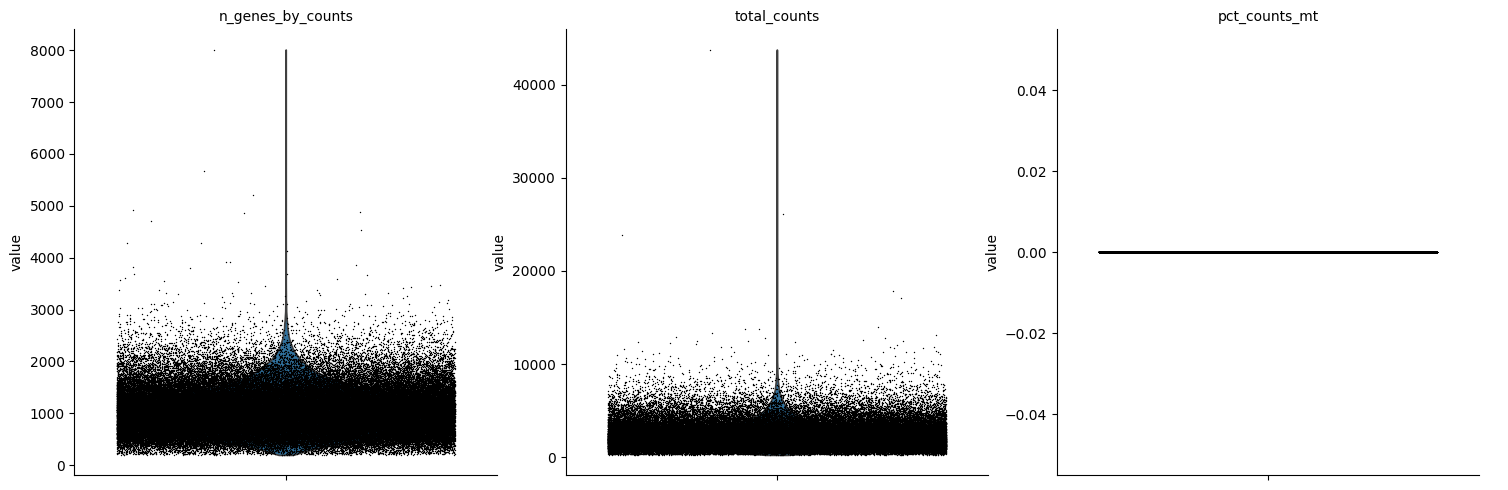

In [20]:
# Plot QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [21]:
# Filter cells based on QC metrics (adjust these thresholds as needed)
adata = adata[adata.obs.n_genes_by_counts < 3000, :]
adata = adata[adata.obs.total_counts < 15000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]

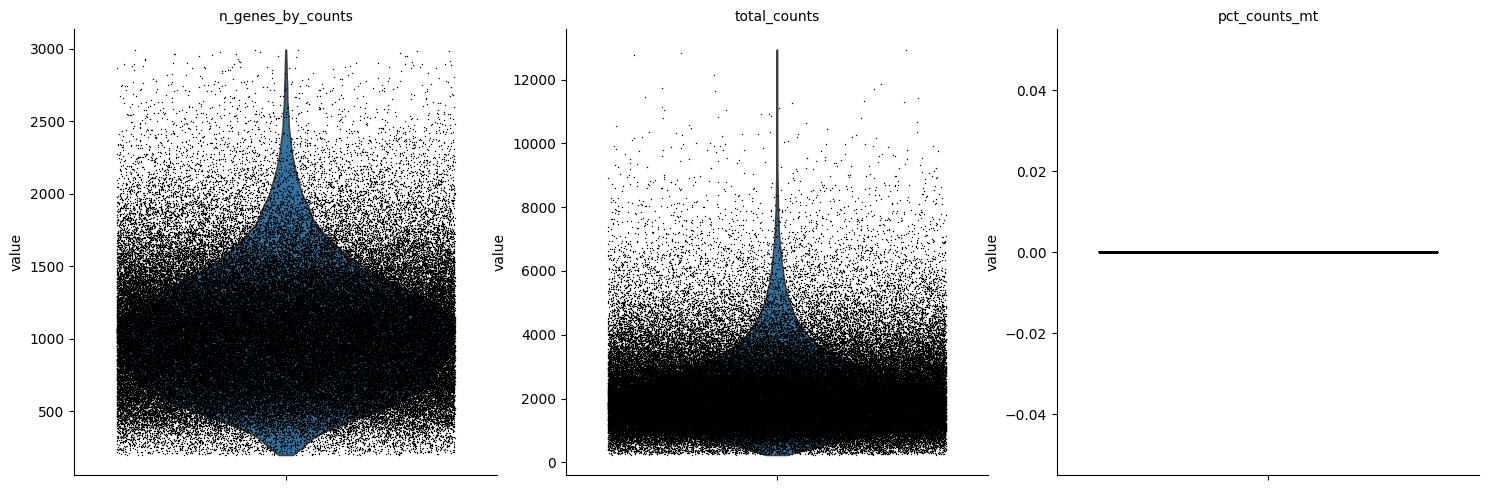

In [22]:
# Plot QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [23]:
# Normalize data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


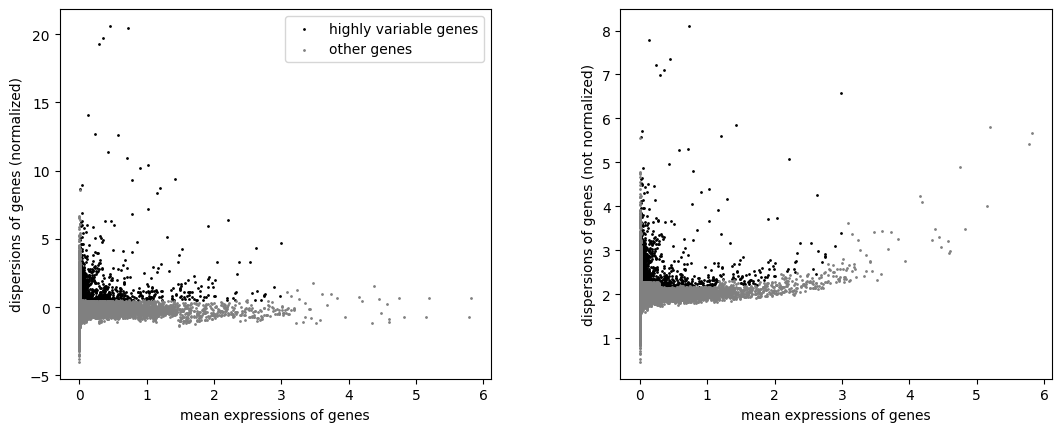

In [24]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Plot highly variable genes
sc.pl.highly_variable_genes(adata)

In [25]:
# Set the .raw attribute of AnnData object to the normalized and logarithmized raw gene expression
adata.raw = adata

# Scale data
sc.pp.scale(adata, max_value=10)

In [26]:
# Perform PCA
sc.tl.pca(adata, svd_solver='arpack')

In [27]:
# Compute neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
# Perform UMAP Embedding
sc.tl.umap(adata)

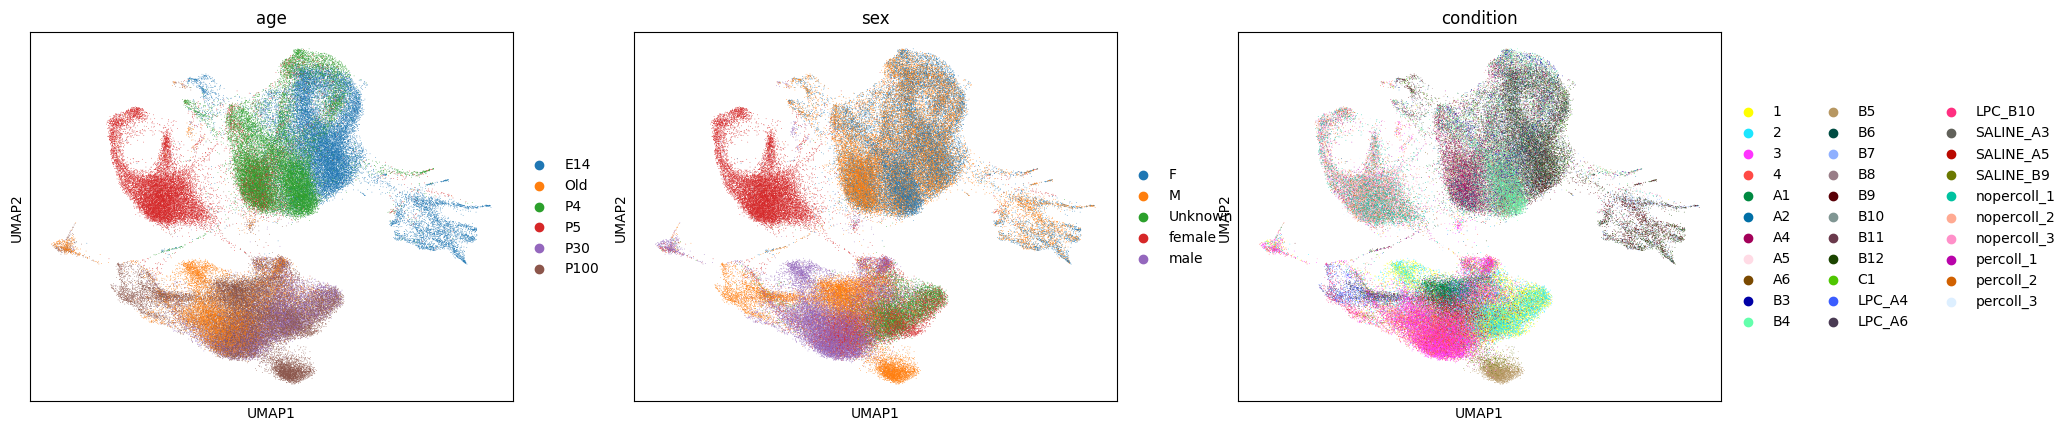

In [29]:
# Plot UMAP
sc.pl.umap(adata, color=['age', 'sex', 'condition'])

In [40]:
# Perform clustering
sc.tl.leiden(adata)

/beegfs/scratch/tmp/ipykernel_5455/476834186.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


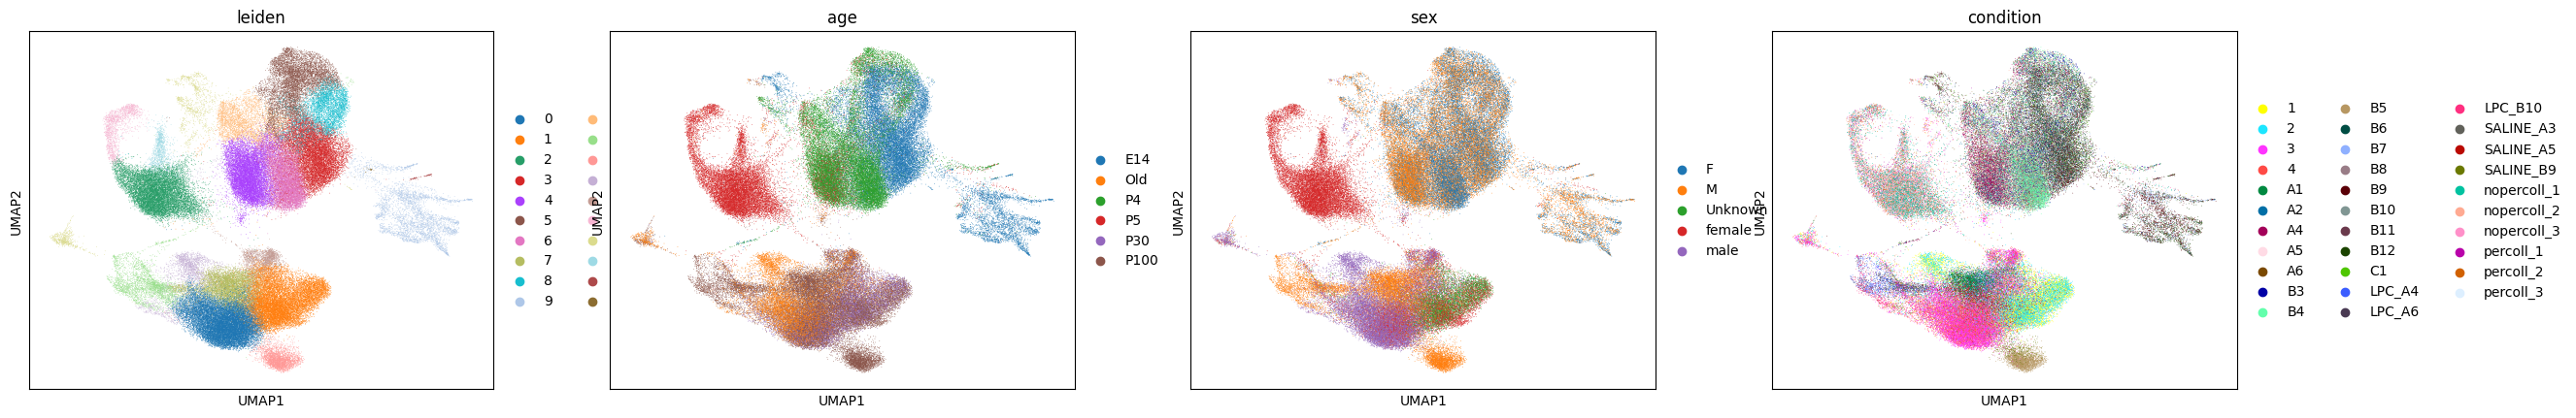

In [41]:
# Plot clustering results
sc.pl.umap(adata, color=['leiden', 'age', 'sex', 'condition'])

In [ ]:
%%capture
# Find marker genes
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

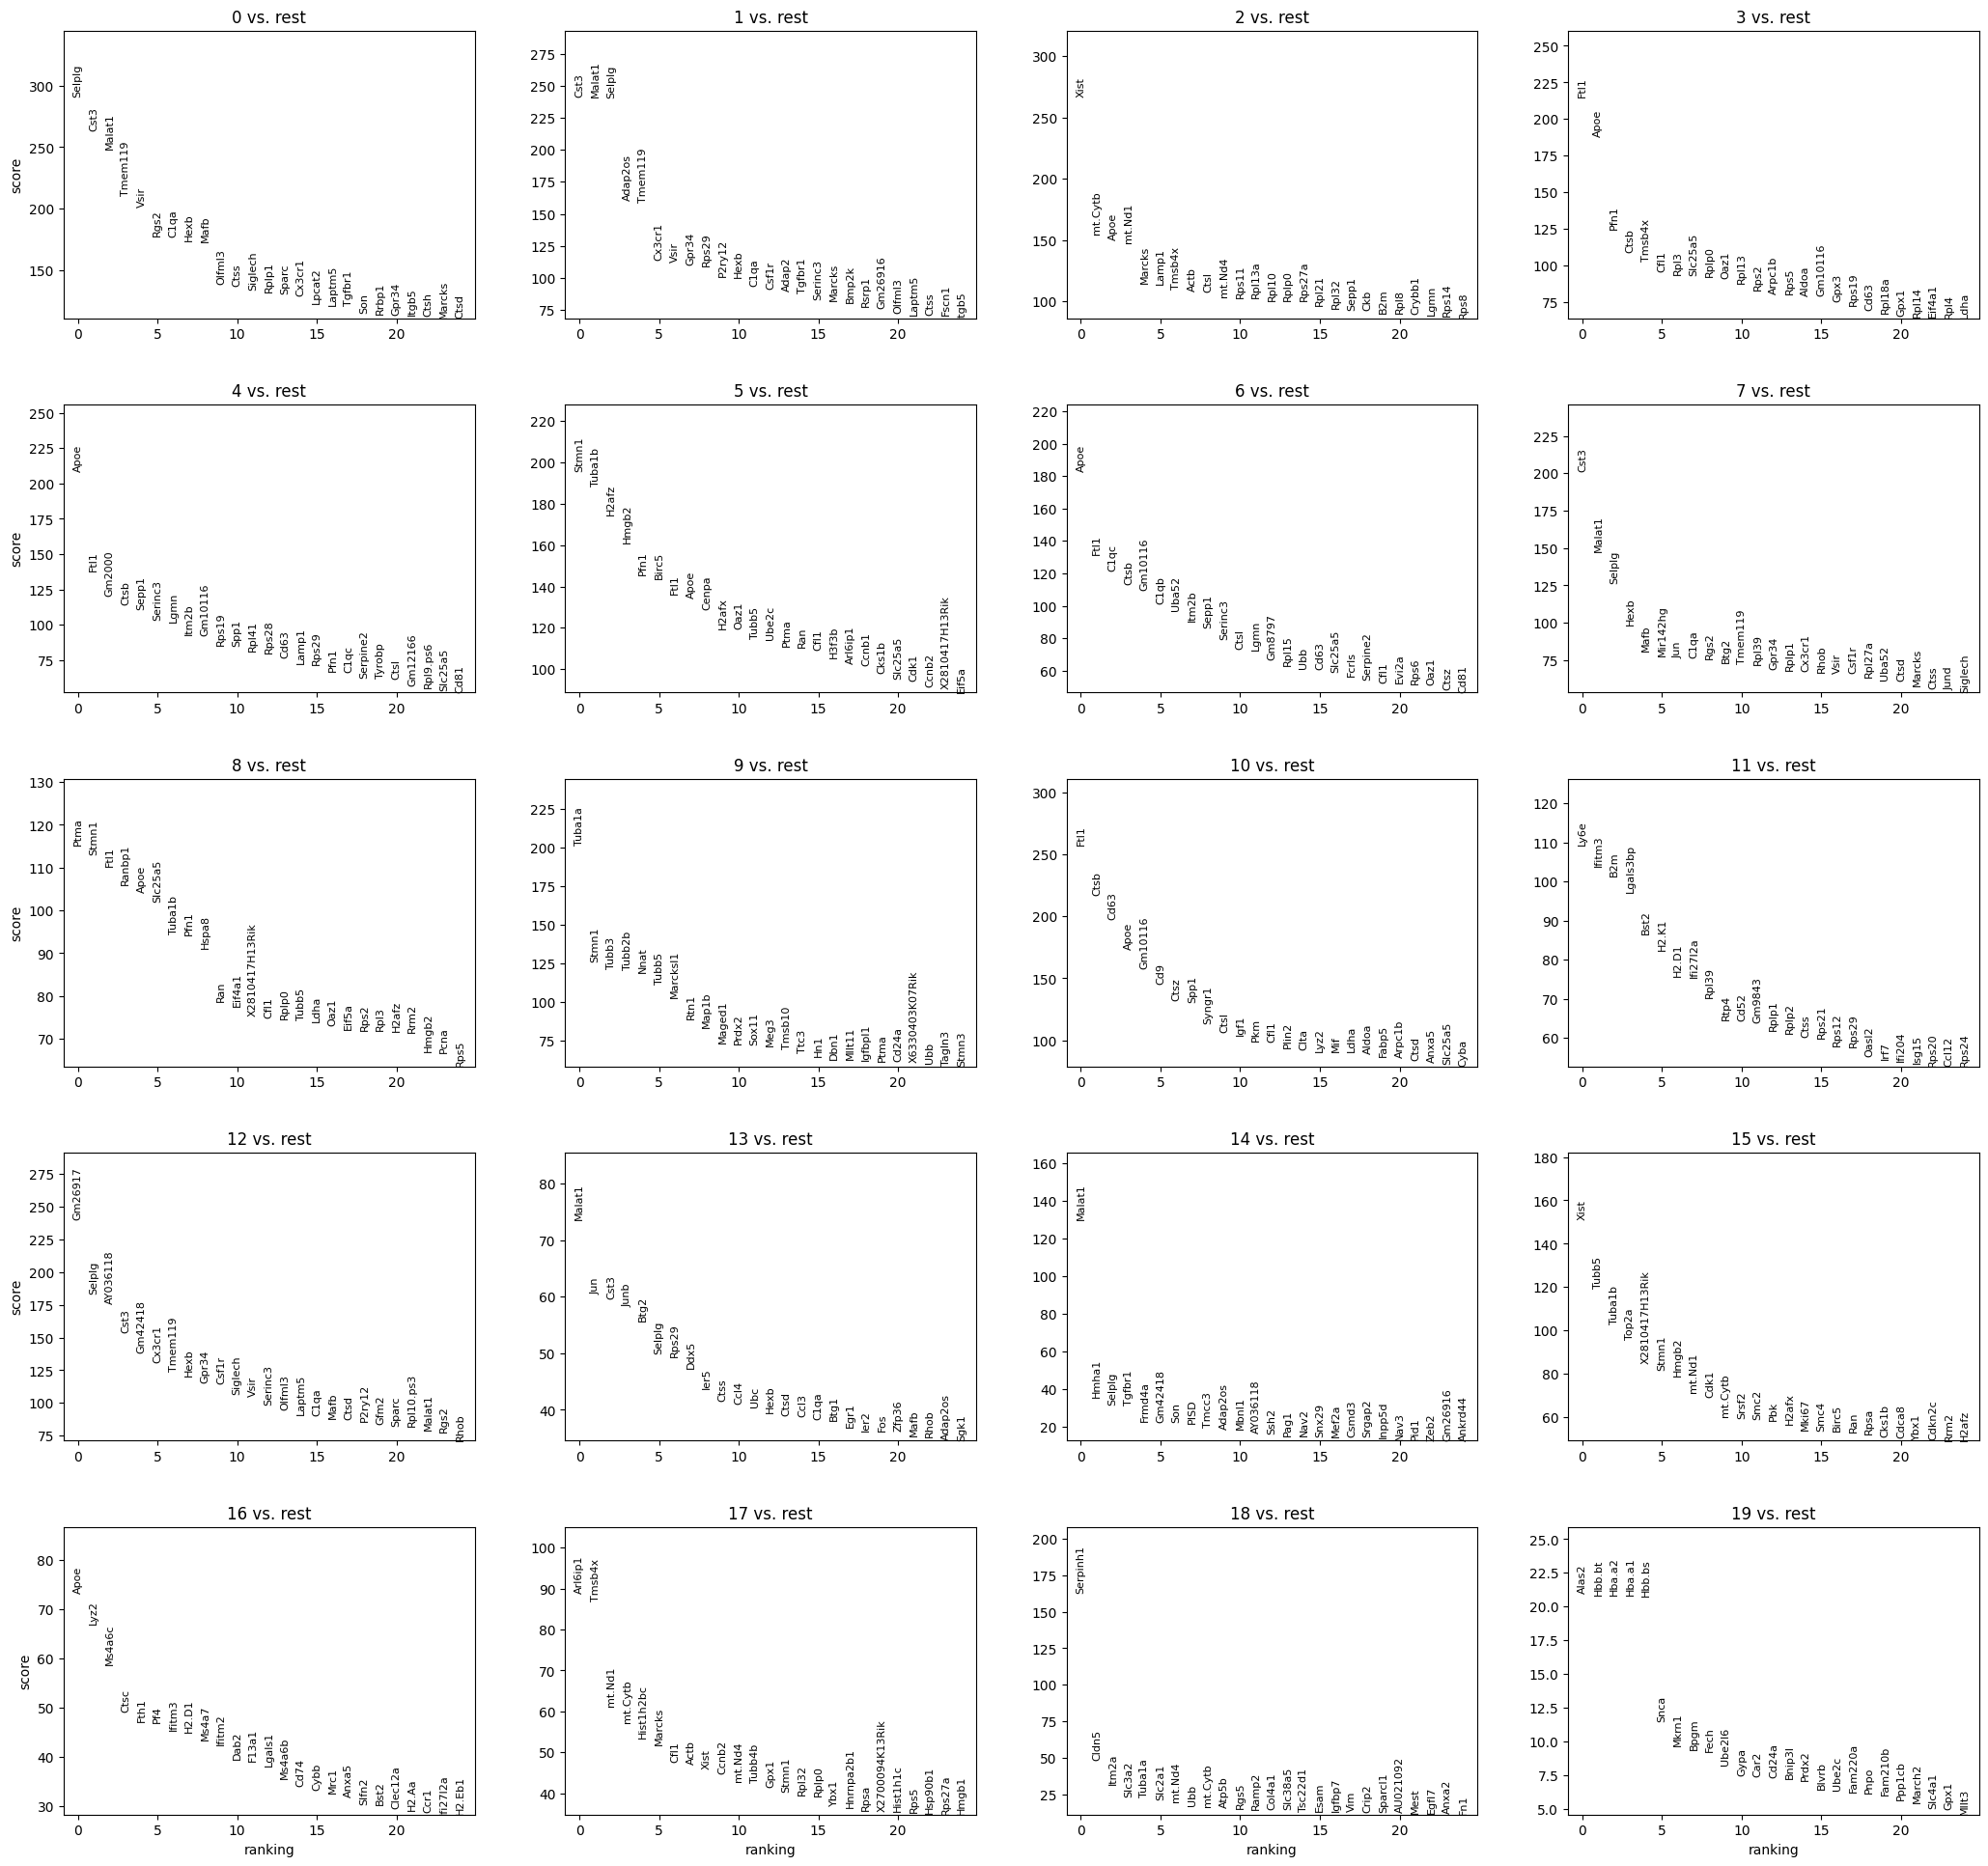

In [44]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [43]:
# Save the results
adata.write('./output/GSE121654_microglia_results.h5ad')

print("Analysis complete. Results saved to 'microglia_results.h5ad'.")

Analysis complete. Results saved to 'microglia_results.h5ad'.
